In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime as tm
import seaborn as sns

In [18]:
### $ Clear all variables

### $ Filename imported by field engineer
filename = 'C:/Users/sambe/Desktop/Spring 2021/M E 266KP/Given Data/testP-1605&A New dataset 2.23.21.xlsx'

### $ Convert to pandas data frame
df = pd.read_excel(filename)

### $ Get the number of rows and columns in the file (# of covariates and sampling will probably be different)
number_rows = len(df.index)
number_cols = len(df.columns)

### $ Create empty data frames with the three points per covariate (value, times, good/bad)
variables = pd.DataFrame()
times = pd.DataFrame()
goodbad = pd.DataFrame()

In [19]:
### $ Sort out whole excel file to place the column in the right data frame (value, times, good/bad)
### $ Relabeled with Variable i names
### $ Iterates over the number of columns
for i in range(number_cols):
    ### $ Puts column title into str
    str = df.columns[i]
    ### $ if searches for a title that starts with 'Pen Name'
    if str.startswith('Pen Name'):
        ### $ takes variables from column and puts in separate 'variables' dataframe
        s = df.iloc[1:,i]
        variables = pd.concat([variables,s.rename('Value')], axis = 1)
    ### $ elif searches for a title that starts with 'Units'
    elif str.startswith('Units'):
        ### $ takes variables from column and puts in separate 'goodbad' dataframe
        s = df.iloc[1:,i]
        goodbad = pd.concat([goodbad,s.rename('GOOD/BAD')],axis = 1)
    ### $ This is for the blank columns in between variable columns
    elif str.startswith('Unnamed'):
        ### $ Skips over empty columns
        continue
    ### $ This is an else because the pen names vary and will be different for every pump/variable
    else:
        ### $ takes variables from column and puts in separate 'times' dataframe
        s = df.iloc[1:,i]
        times = pd.concat([times,s.rename('Time')], axis = 1)

In [20]:
### S convers all datetime to Timestamp
for j in range(len(times.columns)):
    ### $ iterates over only rows with data (aka without nan)
    for i in range(len(times.iloc[:,j].dropna())):
        ### $ Some of the times are in datetime format
        if type(times.iloc[i,j]) == type(tm(2020, 2, 25, 11, 48, 37)):
            times.iloc[i,j] = pd.Timestamp(times.iloc[i,j])
        ### $ Some of the times are in string format, so this will convert to a timestamp if a str
        elif type(times.iloc[i,j]) == type('hey'):
            tempa = tm.strptime(times.iloc[i,j],'%m/%d/%y %H:%M:%S %p')
            tempb = tm.timestamp(tempa)
            times.iloc[i,j] = pd.Timestamp(tempb, unit = 's')
            
        ### $ I truly hope that the time does not hit this else 
        else:
            print(type(times.iloc[i,j]))
            continue

In [21]:
for j in range(len(times.columns)):
    for i in range(len(times.iloc[:,j].dropna())):
        a = times.iloc[i,j]
        times.iloc[i,j] = a.timestamp()

In [22]:
### $ interpolates for BAD Values
### $ Excludes last row because you can't interpolate a machine being on or off
for j in range(len(variables.columns)-1):
    for i in range(len(variables.iloc[:,j].dropna())):
        str = goodbad.iloc[i,j]
        ### $ If the value is bad and the value has no prior value to interpolate from, just use next good value
        ### $ Needs improvement: could back interpolate and take care of case in which there are consecutive bad values     
        if str.startswith('B'):# and i == 0:
            variables.iloc[i,j] = np.nan
#            goodbad.iloc[i,j] = 'INT'
        ### $ Else if bad, then interpolate between the two good points
#        elif str.startswith('B'):
#            t1 = times.iloc[i-1,j]
#            t2 = times.iloc[i,j]
#            t3 = times.iloc[i+1,j]
#            a = variables.iloc[i-1,j]
#            c = variables.iloc[i+1,j]
#            variables.iloc[i,j] = ((t2-t1)/(t3-t1))*(c-a)+a
#            goodbad.iloc[i,j] = 'INT'

In [23]:
### $ Align times via binning
### $ kappa designates the grouping size
### $ Any timestamp outside of the bin will be group later



### $ Sets to dataframes: windows and shutters. windows is the number row that is being looked at for that variable. shutters is end of the length of that variable
### $ column titles designate which variable is being investigated
windows = pd.DataFrame()
shutters = pd.DataFrame()
for j in range(len(variables.columns)):
    w = pd.DataFrame([0], columns = [f'{j}'])
    windows = pd.concat([windows, w], axis = 1)
    temp = variables.iloc[:,j]
    s = pd.DataFrame([len(temp.dropna())], columns = [f'{j}'])
    shutters = pd.concat([shutters, s], axis = 1)

In [24]:
binsize = 86400*2 #seconds

### $ abstime is the merged and grouped times of all the variables
abstime = pd.DataFrame([[0]], columns = ['Time'])
### $ vars is the merged and grouped variables
vars = pd.DataFrame([[0]])
### $ This creates a data frame with the exact number of columns as the number of variables
for j in range(len(variables.columns)):
    a = ['NaN']
    vars[f'Variable {j}'] = a
vars.drop(columns = [0])
### $ counter just used for progress, I guess
#counter = 
### $ Flag1 designates that this is the very first time through the while statement. This flag is used for formatting the data
Flag1 = 0
### $ This iterates until each individual variable has its respective bin


In [25]:
while max(shutters.iloc[0,:]-windows.iloc[0,:]) != 0:
    timenow = []
    ### $ timenow is built and designates the exact timestamps that are to be compared and binned, if possible 
    for k in range(len(variables.columns)):
        timenow.append(times.iloc[windows.iloc[0,k],k])
    ### $ now is just the earliest times in the timenow group          
    now = min(timenow)
    now = now - (now % binsize)
    ### $ next we round now to the nearest bin value ### $### $### $ Really want to improve this later
    #now = now.round(freq = f'{bin}T')
    ### $ a is a pd.DataFrame created to append to the abstime dataframe
    a = pd.DataFrame([[now]], columns = ['Time'])
    abstime = abstime.append(a, ignore_index = True)
    ### $ Flag0 designates that this is the first time through that specific row. This is also for formatting and allows the rest of the variables to be placed on the right row.
    Flag0 = 0
   
    for l in range(len(variables.columns)):
        ### $ Makes sure that the time is within that bin, if not the program skips any input into the times or variables dataframes
        if times.iloc[windows.iloc[0,l],l] - now <= binsize:
            ### $ If this is the first time through the row
            if Flag0 == 0:
                ### $ Appends a to a brand new row of the variables dataframe. This in affect adds a row to the dataframe
                a = pd.DataFrame([variables.iloc[windows.iloc[0,l],l]], columns = [f'Variable {l}'])
                vars = vars.append(a, ignore_index = True)
                ### $ If this is the first time throught the while statement
                if Flag1 == 0:
                    ### $ Formatting
                    vars = vars.drop(columns = [0])
                    vars = vars.drop([0])
                    Flag1 = 1
                ### $ If the time is within the bin, it assigns that variable the bin (group) time
                times.iloc[windows.iloc[0,l],l] = now
                ### $ If the time and variable make it into the bin, the window moves to the next value, one row down
                windows.iloc[0,l] +=1
                Flag0 = 1
                #counter += 1
                #print(counter)
            ### $ If this is not the first time through the row, the program does not have to append another row, but can insert the value right into the cell
            else:
                vars.iloc[windows.iloc[0,l],l] = variables.iloc[windows.iloc[0,l],l]
                times.iloc[windows.iloc[0,l],l] = now
                ### $ Still moves the window because it was binned
                windows.iloc[0,l] +=1
        ### $ If its not in the bin, ignore it.
        else:
            continue

In [26]:
### $ Formatting
abstime = abstime.drop([0])
### $ Also formatting
vars.index += 1
a = pd.DataFrame()
abstimes = pd.DataFrame()
var = pd.DataFrame()
for i in range(len(abstime)-1):
    if abstime.iloc[i,0] == abstime.iloc[i+1,0]:
        b = pd.DataFrame([vars.iloc[i,:]], columns = vars.columns.values)
        a = pd.concat([a, b])
    else:
        try:

            t = pd.DataFrame([abstime.iloc[i,0]], columns = ['Time'])
            z = pd.DataFrame()
            for j in range(len(vars.columns)):
                r = pd.DataFrame([a.iloc[:,j].mean()], columns = [f'Variable {j}'])
                z = pd.concat([z,r], axis = 1)
            abstimes = pd.concat([abstimes, t], ignore_index = True)
            var = pd.concat([var,z], ignore_index = True)
            a = pd.DataFrame()
        except IndexError:
                continue


In [37]:
for i in range(len(abstimes)):
    abstimes.iloc[i,0] = pd.to_datetime(abstimes.iloc[i,0], unit = 's')

#for i in range(len(abstime)):
#    abstime.iloc[i,0] = tm.strptime(abstime.iloc[i,0],'%Y-%m-%d %H:%M:%S')


fixed = pd.concat([abstimes,var], axis = 1)
fixed.set_index('Time', inplace = True)
fixed.to_excel('interpolatedvar.xlsx')

fixed

,Variable 0,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7,Variable 8
Time,,,,,,,,,
2020-02-24,2.455000,16.8300,624.215,41.805,-1.1000,0.0150,0.0400,0.02,0.1800
2020-02-26,3.272500,17.1960,625.710,48.122,-1.3800,0.0300,0.0375,0.02,0.1325
2020-02-28,3.392500,17.0925,624.136,49.852,-1.4060,0.0300,0.0340,0.02,0.2000
2020-03-01,3.480000,17.3025,622.545,49.360,-1.1975,0.0425,0.0375,0.02,0.1775
2020-03-03,3.820000,17.2200,622.144,48.450,-1.4220,0.0220,0.0360,0.02,0.1825
...,...,...,...,...,...,...,...,...,...
2021-02-12,3.017500,17.6400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-14,2.620000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-16,2.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
merged = pd.read_excel('C:/Users/sambe/source/repos/PythonApplication/PythonApplication/Merged Dataset.xlsx', index_col = None)

In [43]:
merged.drop('Unnamed: 0', axis = 1,inplace = True)

In [45]:
merged.set_index('Time', inplace = True)

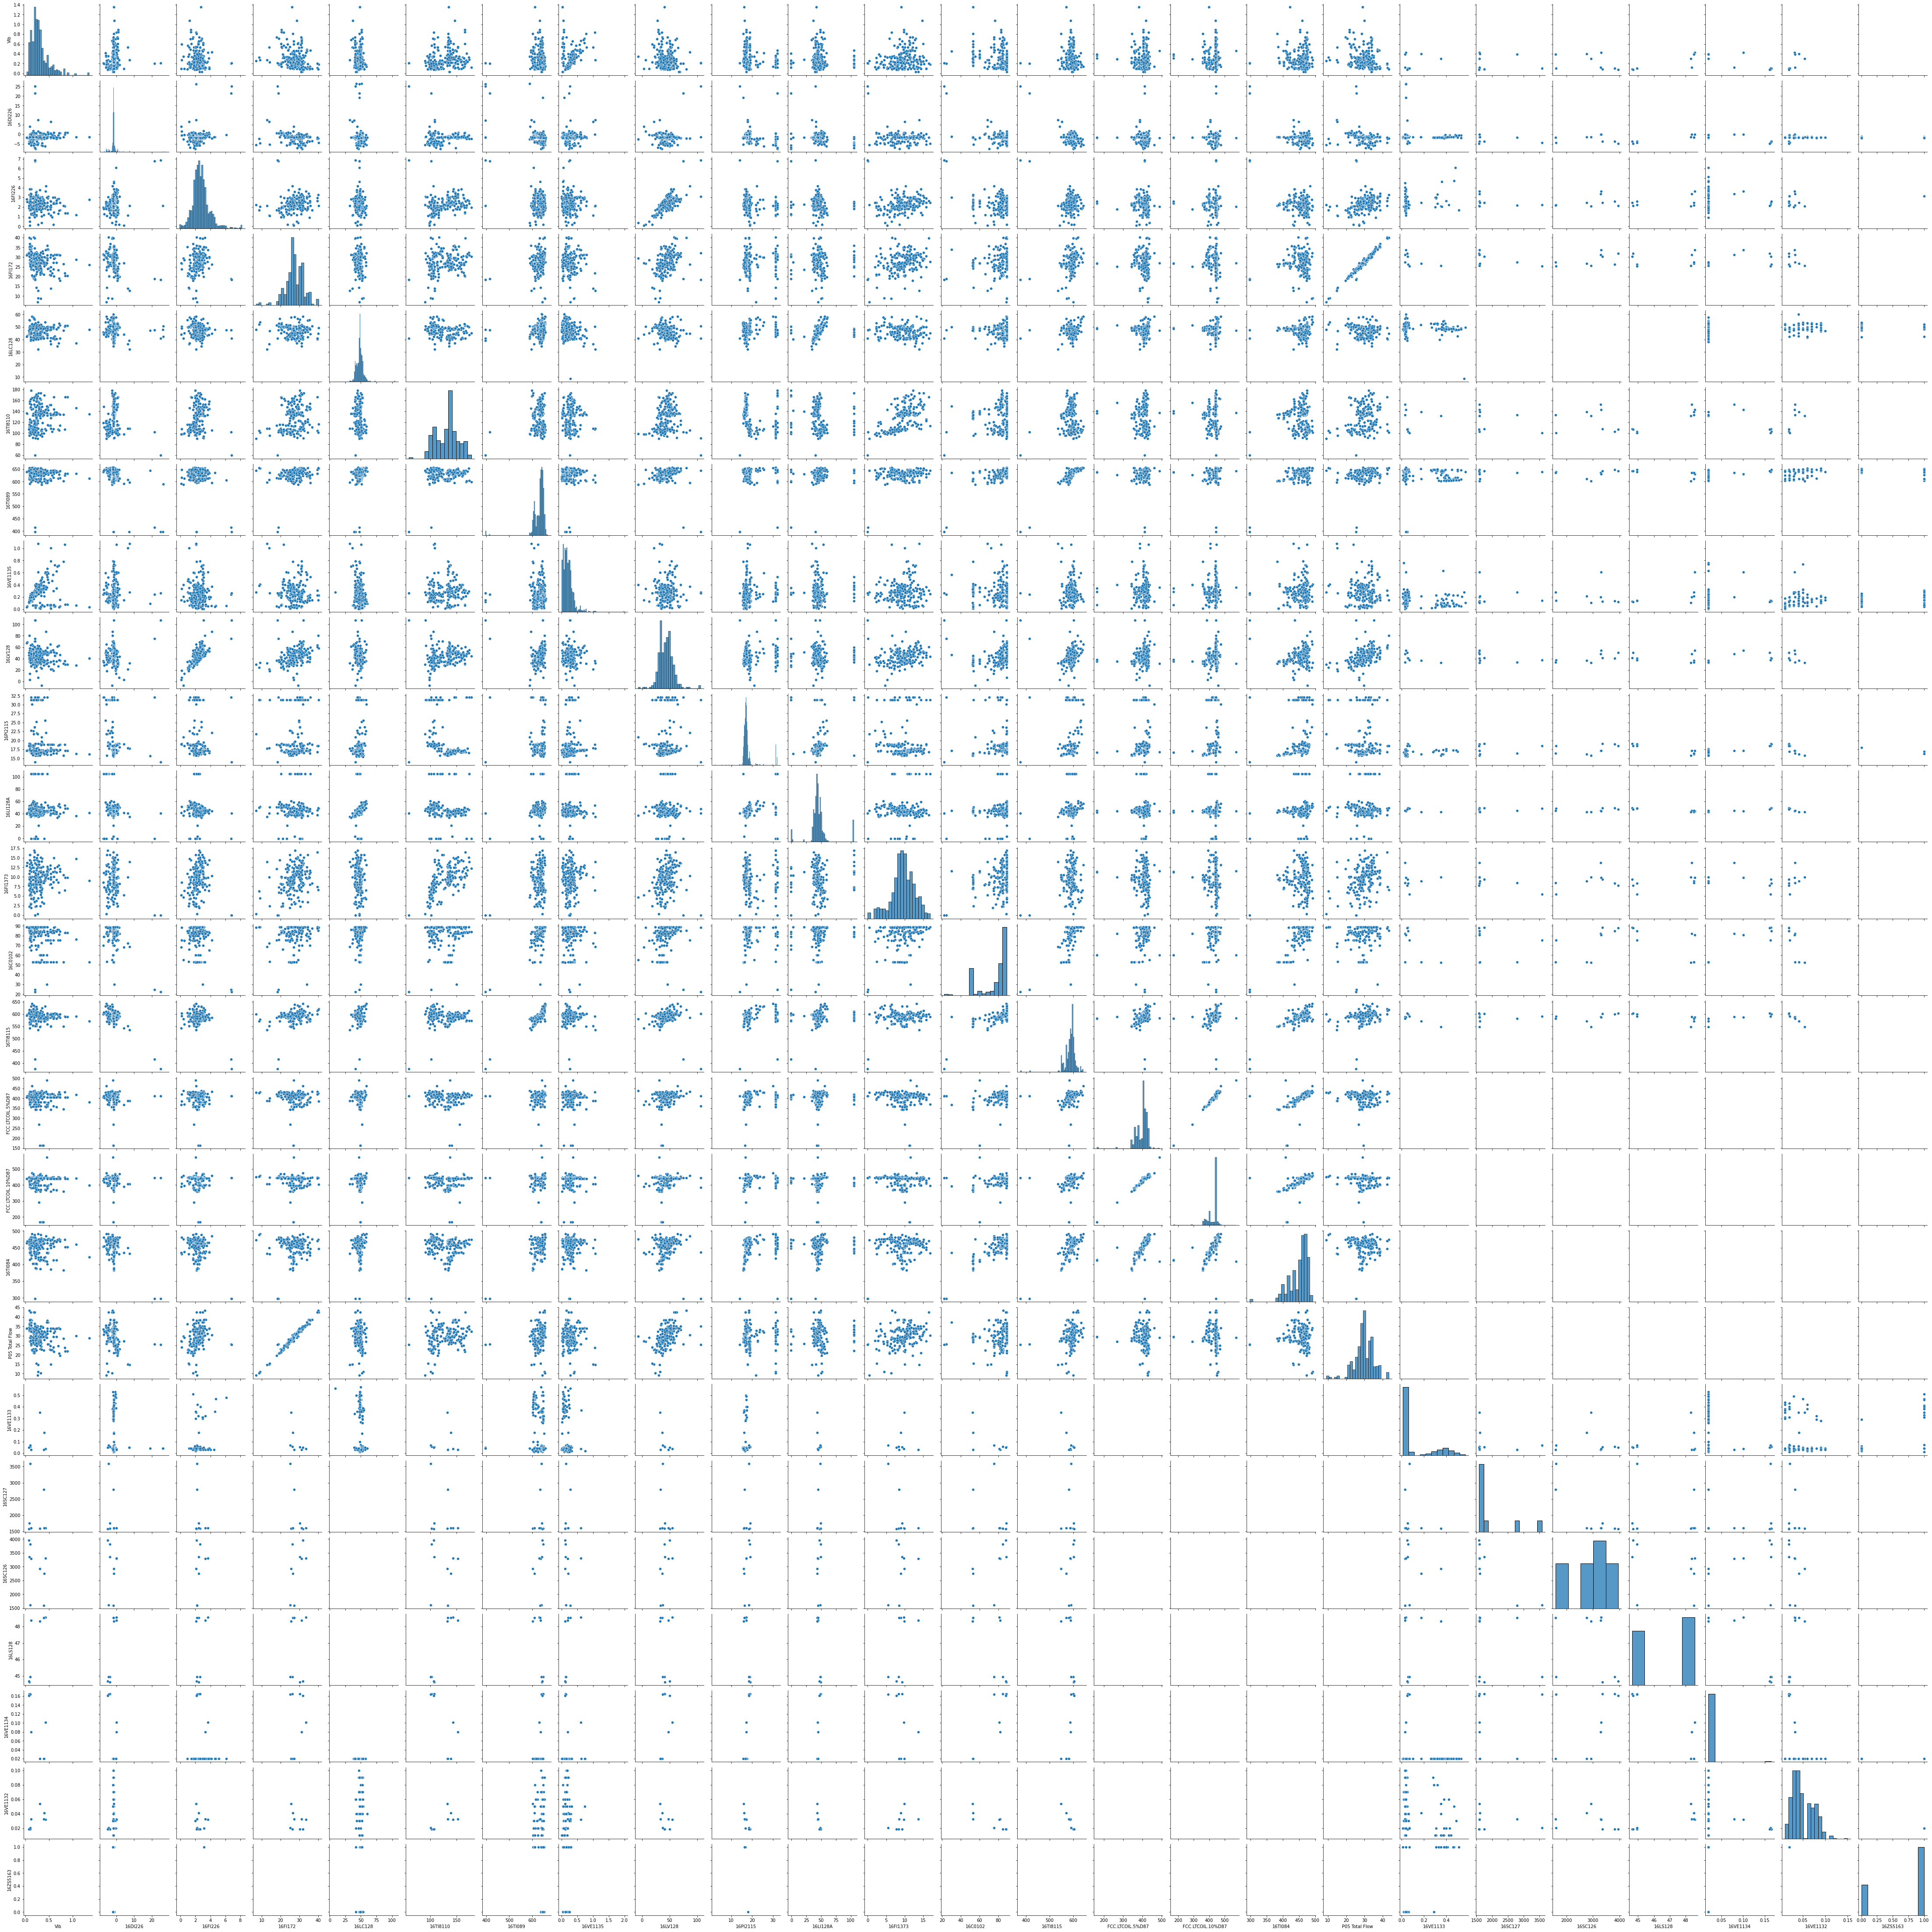

In [47]:
sns.pairplot(data = merged)